# Rick and Morty ChatBot

In this project, I will be building a chat bot using long-term short memory cells and a bi-directional dynamic recurrent neural network.

The dataset was obtained on Kaggle: [Rick and Morty]("https://www.kaggle.com/datasets/andradaolteanu/rickmorty-scripts").

5 columns and 2487 rows
(Goes up to Season 3 Episode 7)

The objective of this project is to be able to speak to Rick and his respective personality.

### Import necessary packages:

In [1]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import csv
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
tf.__version__

'2.7.0'

Create a JSON file from queried dataset converted into csv files.
(Query in the dataset can be found in query file)


### rick_responses:

In [2]:
#CSV TO JSON SCRIPT
def make_json(csvFilePath, jsonFilePath):

    data = {}

    with open(csvFilePath, encoding = 'utf-8') as csvf:
        csvReader = csv.DictReader(csvf)

        for rows in csvReader:
            key = rows['tag']
            data[key] = rows
    
    with open(jsonFilePath, 'w', encoding = 'utf-8') as jsonf:
        jsonf.write(json.dumps(data, indent = 4))


### First, we add the contents of rick_response.csv to the content.json file
It is in comments because I don't want to run the cell multiple times and keep overwriting the JSON file

In [3]:
#csvFilePath = r'/Users/turk/Jupyter Notebooks/Projects/Rick and Morty ChatBot/rick_responses.csv'
#jsonFilePath = r'/Users/turk/Jupyter Notebooks/Projects/Rick and Morty ChatBot/content.json'

#make_json(csvFilePath, jsonFilePath)

Not shown, but I had to clean up the JSON file manually to take out unneccessary lines that my query could not pull out.
I also had to format it so that this next sequence of code was able to read it into Python and be utilized for the tokenizer.

### Getting the JSON data into lists in Python based on 'tags'

In [4]:
#import the just made JSON file into python
with open('content.json') as content:
    data1 = json.load(content)

In [5]:
#put JSON data into lists
tags = []
inputs = []
responses = {}
for intent in data1['intents']:
    responses[intent['tag']] = intent['responses']
    for lines in intent['input']:
        inputs.append(lines)
        tags.append(intent['tag'])

In [6]:
#convert to dataframe using Pandas
data = pd.DataFrame({"inputs": inputs, "tags": tags})

In [7]:
#print the data
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,nice to meet you,greeting
3,"hi, is this is the Rick",greeting
4,hi,greeting
...,...,...
59,which place do you live in ?,whereareyou
60,where are you currently at,whereareyou
61,where do you currently ?,whereareyou
62,you are from where,whereareyou


## Pre-processing Data!

This is the part where I will remove punctuations, converting to lowercase, and encoding the textual data into numerical data

In [8]:
#remove punctuations
#import the string library
import string

data['inputs'] = data['inputs'].apply(lambda word:[letters.lower() for letters in word if letters not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda word: ''.join(word))
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,nice to meet you,greeting
3,hi is this is the rick,greeting
4,hi,greeting
...,...,...
59,which place do you live in,whereareyou
60,where are you currently at,whereareyou
61,where do you currently,whereareyou
62,you are from where,whereareyou


Now, using Tensorflow, we will tokenize (assign a unique token for every distinct word) the data and also pad it so that all data can be the same length for the recurrent neural network.

In [9]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

#apply the padding to make sure all data is the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(data['tags'])

Not shown: How difficult it was to run this code without updating these 3 packages:

scikit-learn
numpy: version 1.9.5
matplotlib

had to reinstall all packages in the end with:
$conda install scikit-learn numpy=1.9.5 matplotlib

In [10]:
input_shape = x_train.shape[1]
print(input_shape)

8


In [11]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)
output_length = label_encoder.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  71
output length:  7


# Neural Network
This Network contains an embedding layer (which I learned is one of the most powerful concepts for the field of Natural Language Processing).
The outputs of the embedding layer is the input of the recurrent layer with long short term memory gate. The output then flattens and a regular dense layer is used with a softmax activation function.

The main part is the embedding layer which gives has a corresponding vector (probability) for each word in the dataset.

In [12]:
# creating the model

i = Input(shape = (input_shape,)) # input layer
x = Embedding(vocabulary + 1, 10)(i) # embedding layed
x = LSTM(10, return_sequences = True)(x) # LSTM gate (on numpy version 1.19.5)
x = Flatten()(x) # flattens outputs
x = Dense(output_length, activation = "softmax")(x) # converts into vectors of probability
model = Model(i, x) # the model

In [13]:
# compiling the model

model.compile(loss = "sparse_categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])

In [14]:
# train the model

train = model.fit(x_train, y_train, epochs = 200)

2022-07-24 19:14:38.548344: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200
2/2 [==============================] - 1s 3ms/step - loss: 1.9445 - accuracy: 0.1875
Epoch 2/200
2/2 [==============================] - 0s 3ms/step - loss: 1.9421 - accuracy: 0.1719
Epoch 3/200
2/2 [==============================] - 0s 3ms/step - loss: 1.9402 - accuracy: 0.1562
Epoch 4/200
2/2 [==============================] - 0s 3ms/step - loss: 1.9385 - accuracy: 0.2031
Epoch 5/200
2/2 [==============================] - 0s 3ms/step - loss: 1.9367 - accuracy: 0.2188
Epoch 6/200
2/2 [==============================] - 0s 3ms/step - loss: 1.9347 - accuracy: 0.2188
Epoch 7/200
2/2 [==============================] - 0s 2ms/step - loss: 1.9327 - accuracy: 0.2188
Epoch 8/200
2/2 [==============================] - 0s 2ms/step - loss: 1.9305 - accuracy: 0.2188
Epoch 9/200
2/2 [==============================] - 0s 2ms/step - loss: 1.9284 - accuracy: 0.2188
Epoch 10/200
2/2 [==============================] - 0s 2ms/step - loss: 1.9259 - accuracy: 0.2188
Epoch 11/200
2/2 [===========

# Model Analysis

The model has an accuracy of 98.44% (it fluctuates +/- 2.00%).

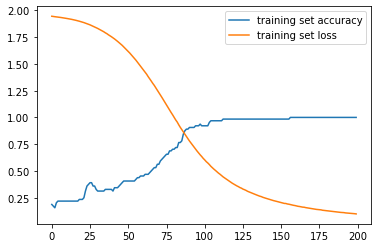

In [15]:
#plotting analysis
plt.plot(train.history['accuracy'], label = 'training set accuracy')
plt.plot(train.history['loss'], label = 'training set loss')
plt.legend()

# Testing the model

I managed to test the model the way a human would interact with chatbot. This is a much smaller dataset, so if there are mistakes, a much larger dataset would be more accurate.

In [ ]:
#chatting
import random

while True:
    texts_p = []
    prediction_input = input('You: ')

    #removing punctuation and converting to lowercase
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts_p.append(prediction_input)

    #tokenizing and padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    #getting an output from the model
    output = model.predict(prediction_input)
    output = output.argmax()

    #finding the right tag and predicting
    response_tag = label_encoder.inverse_transform([output])[0]
    print("Rick: ", random.choice(responses[response_tag]))
    if response_tag == "goodbye":
        break


# Conclusion

Here is my Rick and Morty: Rick Chatbot. The accuracy when testing the model will work sometimes. There are still some bugs to fix, but I learned a lot. Again, this chatbot utilizes: tensorflow, keras, numpy, matplotlib, scikit-learn, JSON, nltk, natural language-processing, long short-term memory, recurrenct neural networks, encoding, tokenizing, embedding, padding, flattening, training, and testing. This was difficult, but I learned a lot of new concepts and troubleshooting steps. 

## Thank you and enjoy my Rick and Morty Chatbot!

(Not seen is the amount of bugs I had to go through to get my environment to work, my JSON file formatted, and correct version installs.)